# Import Library, Load Data

## LSTM2 > LSTM3

LSTM 3에서는 내일의 날씨를 함께 학습시킵니다.

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import pandas as pd
from pandas import DataFrame, Series

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_init = pd.read_csv('coffee_weather_janghoo.csv')
df_init = df_init.drop(['weather_mintemp', 'weather_maxwindspeed', 'weather_mintemp'], axis = 1)
df_weather_columns = df_init.iloc[:, 6:]
df_init.head()

,datetime,americano,cafelatte,cafemoca,caramelmatk,icedamericano,weather_avgtemp,weather_avgmoist,weather_avgwindspeed,weather_rain,weather_maxtemp
0,2016-06-24,35.18592,23.27069,15.43382,26.34946,9.55617,22.548148,80.461538,1.544444,5.124074,26.216667
1,2016-06-25,33.22670,23.75049,15.55377,25.54978,8.91643,22.292593,67.897436,2.177778,0.037037,27.259259
2,2016-06-26,36.98520,26.30947,17.15313,27.38904,11.07556,23.737037,64.256410,1.805556,0.000000,30.659259
3,2016-06-27,37.26509,24.39024,14.51419,25.26989,11.07556,23.538889,65.205128,1.114815,0.000000,29.077778
4,2016-06-28,37.18512,23.23070,14.19432,24.99000,12.23510,24.062963,65.205128,1.287037,0.000000,30.133333


In [5]:
df_weather_columns.head()

,weather_avgtemp,weather_avgmoist,weather_avgwindspeed,weather_rain,weather_maxtemp
0,22.548148,80.461538,1.544444,5.124074,26.216667
1,22.292593,67.897436,2.177778,0.037037,27.259259
2,23.737037,64.256410,1.805556,0.000000,30.659259
3,23.538889,65.205128,1.114815,0.000000,29.077778
4,24.062963,65.205128,1.287037,0.000000,30.133333


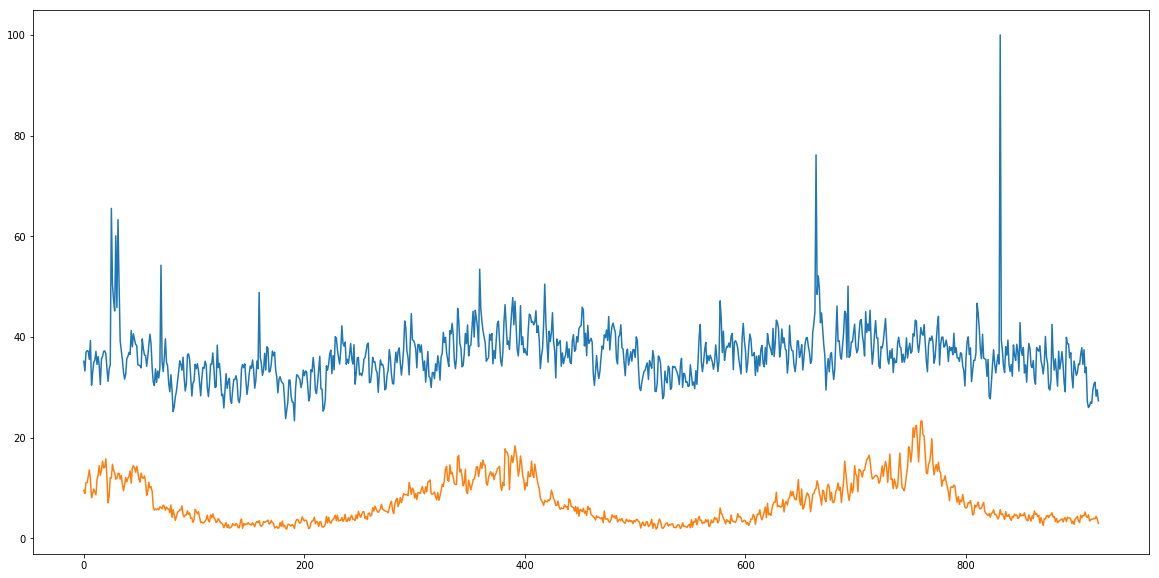

In [6]:
df_americano_and_icedamericano = df_init.drop(['caramelmatk', 'cafemoca', 'cafelatte'],axis = 1)
df_caffelatte_and_americano = df_init.drop(['caramelmatk', 'cafemoca', 'icedamericano'], axis = 1)


df_americano_and_icedamericano.head()

plt.figure(figsize = [20,10])
plt.plot(df_americano_and_icedamericano.iloc[:, 1:3])

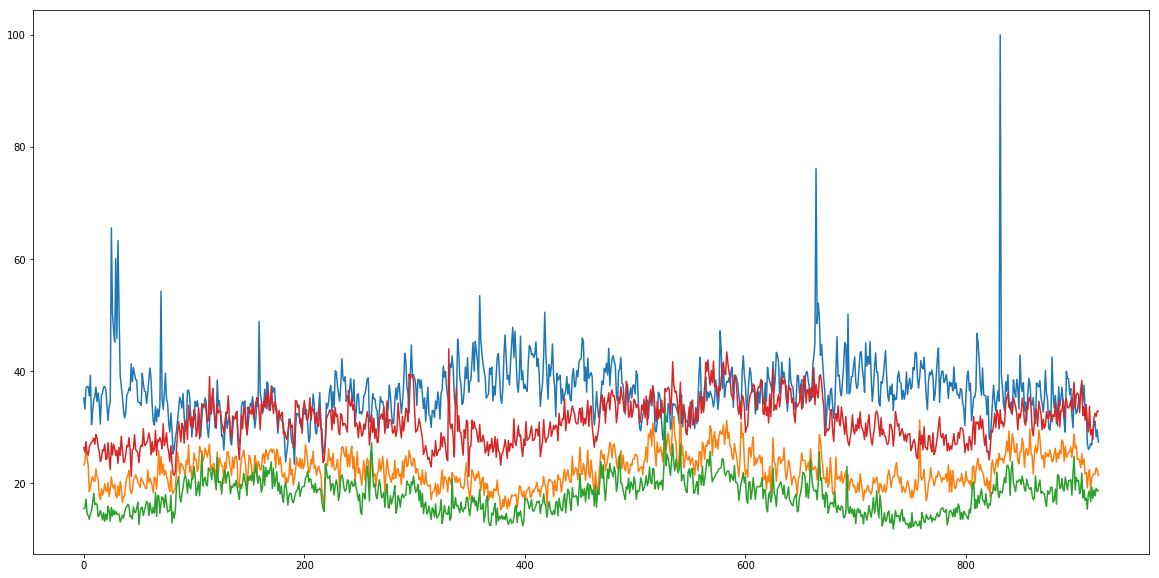

In [7]:
plt.figure(figsize = [20,10])
plt.plot(df_init.iloc[:, 1:5])

# Model

In [8]:
# 1. RNN
# 2. LSTM

## Hyper parameters

In [9]:
#about X
timesteps = sequence_length = 7
data_dim = 5

#about Y and hidden size
hidden_layer_size = 3
hidden_dim = 10
output_dim = 1

#about training
learning_rate = 0.01
epoch = 1


def set_activation_function(string):
    if string == 'tanh' :
        return tf.tanh, string
    elif string == 'relu' :
        return tf.nn.relu, string

#activation function
activation_function, activation_functionname = set_activation_function('tanh') #relu
activation_function, activation_functionname

(<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>, 'tanh')

<h4>Kinds of Hyper parameters</h4>

- timesteps : <br>
- data_dim : data dimension <br>
- hidden_layer_size <br>
- hidden_dim = hidden_dimension <br>
    - https://stackoverflow.com/questions/37901047/what-is-num-units-in-tensorflow-basiclstmcell <br>
    - more hidden dimension, more memorize <br>
    
    


## Data Pre-Processing

In [10]:
#df_xy = df_americano_and_icedamericano.iloc[:,1:]
df_xy = pd.concat([df_weather_columns, df_init['icedamericano']], axis = 1)
np_xy = df_xy.to_numpy()
batch_size = np_size = len(np_xy)
np_xy

array([[ 2.25481481e+01,  8.04615385e+01,  1.54444444e+00,
         5.12407407e+00,  2.62166667e+01,  9.55617000e+00],
       [ 2.22925926e+01,  6.78974359e+01,  2.17777778e+00,
         3.70370370e-02,  2.72592593e+01,  8.91643000e+00],
       [ 2.37370370e+01,  6.42564103e+01,  1.80555556e+00,
         0.00000000e+00,  3.06592593e+01,  1.10755600e+01],
       ...,
       [-7.29245283e+00,  3.36410256e+01,  2.25660377e+00,
         0.00000000e+00, -2.85094340e+00,  4.35825000e+00],
       [-7.72641509e+00,  4.64615385e+01,  1.08113207e+00,
         0.00000000e+00, -1.74339623e+00,  3.83846000e+00],
       [-6.20377359e+00,  5.05641026e+01,  9.84905660e-01,
         0.00000000e+00,  6.22641510e-02,  2.95881000e+00]])

In [11]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


def StandardScaler(data):
#    avg = []
#    for i in range(0, np_xy[0], 1) :
#        np.mean(np_xy[:,i])
    avg = np.mean(np_xy, axis = 0)
    std = np.std(np_xy, axis = 0)
    
    final = (data - avg) / std
    
    return final




#scaled_np_xy = MinMaxScaler(np_xy)
scaled_np_xy = StandardScaler(np_xy)

scaled_np_xy

array([[ 0.8466481 ,  1.12872705,  0.02319154,  0.15854079,  0.68120671,
         0.57899985],
       [ 0.82320154,  0.27196874,  1.23912125, -0.27339971,  0.77539438,
         0.4293087 ],
       [ 0.95572555,  0.02368368,  0.5244959 , -0.27654453,  1.08254992,
         0.93451807],
       ...,
       [-1.89114912, -2.064009  ,  1.39045842, -0.27654453, -1.94475721,
        -0.63724832],
       [-1.93096403, -1.18976583, -0.86631679, -0.27654453, -1.84470155,
        -0.75887266],
       [-1.79126564, -0.91000802, -1.05106083, -0.27654453, -1.68157844,
        -0.96469974]])

In [12]:
# train/test split
train_size = int(len(scaled_np_xy) * 0.7)
train_set = scaled_np_xy[0:train_size]
test_set = scaled_np_xy[train_size - sequence_length:]
print('size : ', train_size)
# Index from [train_size - seq_length] to utilize past sequence

size :  644


In [32]:
# build datasets
def build_dataset(time_series, seq_length): # seq_length : count of time series (timesteps)
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length - 1): # 7개씩 묶는 과정
        _x = time_series[i + 1:i + seq_length + 1, :-1]
        _y = time_series[i + seq_length, -1]  # Next close
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, sequence_length)
#testX, testY   = build_dataset(test_set , sequence_length)
testX, testY = build_dataset(scaled_np_xy, sequence_length) #just full trial

[[ 0.82320154  0.27196874  1.23912125 -0.27339971  0.77539438]
 [ 0.95572555  0.02368368  0.5244959  -0.27654453  1.08254992]
 [ 0.93754597  0.08837768 -0.80164967 -0.27654453  0.9396791 ]
 [ 0.9856284   0.08837768 -0.47100212 -0.27654453  1.03503784]
 [ 1.04203605  0.06215038  0.33961769 -0.27654453  1.05042908]
 [ 1.0121332   1.1217331   0.64893315 -0.19477931  0.8337807 ]
 [ 0.96897795  1.60606382  0.54227265  8.27106574  0.78342459]] -> 0.2328364394342386
[[ 0.95572555  0.02368368  0.5244959  -0.27654453  1.08254992]
 [ 0.93754597  0.08837768 -0.80164967 -0.27654453  0.9396791 ]
 [ 0.9856284   0.08837768 -0.47100212 -0.27654453  1.03503784]
 [ 1.04203605  0.06215038  0.33961769 -0.27654453  1.05042908]
 [ 1.0121332   1.1217331   0.64893315 -0.19477931  0.8337807 ]
 [ 0.96897795  1.60606382  0.54227265  8.27106574  0.78342459]
 [ 0.92803143  1.20740893  0.31117489 -0.0487026   0.82324105]] -> 0.41995154131168866
[[ 0.93754597  0.08837768 -0.80164967 -0.27654453  0.9396791 ]
 [ 0.985

 [-0.45383107 -1.45631797  0.0465361  -0.27654453 -0.35835512]] -> -0.3378636853420959
[[-0.42099499 -2.42973406  0.14051809 -0.27654453 -0.24394041]
 [-0.35948705 -2.16690577 -0.75764383 -0.27654453 -0.03500659]
 [-0.37665042 -1.95492288 -0.81587107 -0.27654453 -0.31387016]
 [-0.55470832 -1.75792676  1.06135375 -0.27654453 -0.53352986]
 [-0.56915003 -1.43455392  0.27206604 -0.27654453 -0.42997361]
 [-0.45383107 -1.45631797  0.0465361  -0.27654453 -0.35835512]
 [-0.50645599 -0.87328981 -0.41411652 -0.27591556 -0.38932067]] -> -0.37528764166747525
[[-0.35948705 -2.16690577 -0.75764383 -0.27654453 -0.03500659]
 [-0.37665042 -1.95492288 -0.81587107 -0.27654453 -0.31387016]
 [-0.55470832 -1.75792676  1.06135375 -0.27654453 -0.53352986]
 [-0.56915003 -1.43455392  0.27206604 -0.27654453 -0.42997361]
 [-0.45383107 -1.45631797  0.0465361  -0.27654453 -0.35835512]
 [-0.50645599 -0.87328981 -0.41411652 -0.27591556 -0.38932067]
 [-0.56201413 -1.67710783 -0.05147081 -0.27151282 -0.59977909]] -> -0

  -3.24782109e-02]] -> -0.7588726645663593
[[ 0.19445944  0.38387187 -0.39177818 -0.27446183 -0.01676817]
 [ 0.18270805  0.31029367 -0.73779011 -0.27654453  0.26396394]
 [ 0.16092132  0.33141728 -1.06830092 -0.27654453  0.35983101]
 [ 0.18555719  0.17929897 -0.85497992 -0.27654453  0.44314444]
 [ 0.15174658 -0.25782262  1.63376511 -0.27654453  0.31265353]
 [-0.11381114 -0.26481656 -0.59543937 -0.27654453 -0.03247821]
 [-0.07490345  0.18454443 -1.00074927 -0.27654453  0.07342018]] -> -0.8337182373423947
[[ 0.18270805  0.31029367 -0.73779011 -0.27654453  0.26396394]
 [ 0.16092132  0.33141728 -1.06830092 -0.27654453  0.35983101]
 [ 0.18555719  0.17929897 -0.85497992 -0.27654453  0.44314444]
 [ 0.15174658 -0.25782262  1.63376511 -0.27654453  0.31265353]
 [-0.11381114 -0.26481656 -0.59543937 -0.27654453 -0.03247821]
 [-0.07490345  0.18454443 -1.00074927 -0.27654453  0.07342018]
 [-0.06708793  0.45905678 -1.01852602 -0.27654453  0.09182275]] -> -0.7308058672596864
[[ 0.16092132  0.33141728 -

 [ 1.30402582  0.53737056 -0.81231572 -0.165847    1.39756837]] -> 1.9262295153499993
[[ 0.83883258  1.16894223 -0.47811282 -0.21066063  0.78794159]
 [ 0.92718192  1.00458452 -1.22118098 -0.24902738  0.8928362 ]
 [ 1.18900178  0.55347504 -0.65943567 -0.27654453  1.26189128]
 [ 1.24608904  0.44681738 -0.41767187 -0.27654453  1.29535048]
 [ 1.23878323  0.52200229 -0.69143382 -0.27654453  1.28999701]
 [ 1.30402582  0.53737056 -0.81231572 -0.165847    1.39756837]
 [ 1.1174728   0.78252675 -0.43189327  0.04831498  1.06080143]] -> 1.6174900652271504
[[ 0.92718192  1.00458452 -1.22118098 -0.24902738  0.8928362 ]
 [ 1.18900178  0.55347504 -0.65943567 -0.27654453  1.26189128]
 [ 1.24608904  0.44681738 -0.41767187 -0.27654453  1.29535048]
 [ 1.23878323  0.52200229 -0.69143382 -0.27654453  1.28999701]
 [ 1.30402582  0.53737056 -0.81231572 -0.165847    1.39756837]
 [ 1.1174728   0.78252675 -0.43189327  0.04831498  1.06080143]
 [ 1.11441455  0.76679038 -0.24345971 -0.26459422  0.98150311]] -> 1.654

 [-1.11997417 -1.47379773 -0.93675297 -0.27654453 -0.97033983]] -> -0.7775846427290489
[[-1.73858944 -2.17717492  2.92080182 -0.27654453 -1.86035478]
 [-1.59791011 -1.98775557  1.2000124  -0.27654453 -1.62547114]
 [-1.42392987 -1.55082826 -0.17590806 -0.27654453 -1.30376084]
 [-1.27152727 -1.00277493 -1.00074927 -0.2718273  -1.16356676]
 [-1.22463416 -1.64427514 -0.24701506 -0.27654453 -1.1197352 ]
 [-1.11997417 -1.47379773 -0.93675297 -0.27654453 -0.97033983]
 [-0.70931966 -1.00908891 -0.02302801 -0.26773904 -0.66050756]] -> -0.5436907653822359
[[-1.59791011 -1.98775557  1.2000124  -0.27654453 -1.62547114]
 [-1.42392987 -1.55082826 -0.17590806 -0.27654453 -1.30376084]
 [-1.27152727 -1.00277493 -1.00074927 -0.2718273  -1.16356676]
 [-1.22463416 -1.64427514 -0.24701506 -0.27654453 -1.1197352 ]
 [-1.11997417 -1.47379773 -0.93675297 -0.27654453 -0.97033983]
 [-0.70931966 -1.00908891 -0.02302801 -0.26773904 -0.66050756]
 [-1.062826   -1.4322446   2.56050399  0.03778281 -0.85266758]] -> -0.

[[ 0.66115937  0.95369436 -0.5402979  -0.27572808  0.71907559]
 [ 0.75740757  1.0811038  -0.40989034 -0.26593077  0.78691571]
 [ 0.79549139  0.54095956 -0.94963273 -0.27654453  0.90094848]
 [ 0.8855077   0.41893362 -0.61274654 -0.26888597  0.95634557]
 [ 0.73663458  0.77962795 -0.46784926 -0.18281691  0.66725801]
 [ 0.49588424 -0.60034189  1.23378823 -0.27654453  0.5085765 ]
 [ 0.21817195 -0.74031282  0.07816272 -0.27654453  0.29540917]] -> -0.6466031354649443
[[ 0.75740757  1.0811038  -0.40989034 -0.26593077  0.78691571]
 [ 0.79549139  0.54095956 -0.94963273 -0.27654453  0.90094848]
 [ 0.8855077   0.41893362 -0.61274654 -0.26888597  0.95634557]
 [ 0.73663458  0.77962795 -0.46784926 -0.18281691  0.66725801]
 [ 0.49588424 -0.60034189  1.23378823 -0.27654453  0.5085765 ]
 [ 0.21817195 -0.74031282  0.07816272 -0.27654453  0.29540917]
 [ 0.47047727  0.57146605 -0.23566529 -0.27654453  0.56052192]] -> -0.6933819109343069
[[ 0.79549139  0.54095956 -0.94963273 -0.27654453  0.90094848]
 [ 0.88

 [ 0.33415783 -0.45678196  2.02438404 -0.27654453  0.32498924]] -> 0.6444905995145187
[[-0.18024305  0.12509589  1.85775216 -0.11411477 -0.24276934]
 [ 0.08004769 -0.97295353  2.66126127 -0.27654453  0.12176874]
 [ 0.40150336 -0.67221388  1.60176696 -0.27654453  0.51273959]
 [ 0.24655221  1.6602669  -0.25768111  1.59603624  0.10487184]
 [ 0.46572012  0.24486721 -0.56699657 -0.27654453  0.64841669]
 [ 0.33415783 -0.45678196  2.02438404 -0.27654453  0.32498924]
 [ 0.14512038 -0.39770152  0.29339814 -0.27654453  0.27300436]] -> 0.9158084331867111
[[ 0.08004769 -0.97295353  2.66126127 -0.27654453  0.12176874]
 [ 0.40150336 -0.67221388  1.60176696 -0.27654453  0.51273959]
 [ 0.24655221  1.6602669  -0.25768111  1.59603624  0.10487184]
 [ 0.46572012  0.24486721 -0.56699657 -0.27654453  0.64841669]
 [ 0.33415783 -0.45678196  2.02438404 -0.27654453  0.32498924]
 [ 0.14512038 -0.39770152  0.29339814 -0.27654453  0.27300436]
 [ 0.13951359  0.47479316  0.54227265 -0.27654453  0.25744583]] -> 0.578

 [-0.81735846 -1.57475492 -0.72671383 -0.27654453 -0.74954378]] -> -0.749517845422376
[[-1.09903618 -1.45043601 -0.97314303 -0.27654453 -1.08405194]
 [-0.95875109  0.83812862  0.15436126  0.45187518 -1.23896388]
 [-0.81240544  1.44189513 -1.3316145  -0.27654453 -0.84353967]
 [-0.74607858  1.13595728 -1.12959516 -0.27654453 -0.5767316 ]
 [-0.63126706  0.6659925  -0.81532409 -0.27654453 -0.61301126]
 [-0.81735846 -1.57475492 -0.72671383 -0.27654453 -0.74954378]
 [-0.95019576 -0.66135486 -1.15499677 -0.27654453 -1.06212101]] -> -0.8992089909744471
[[-0.95875109  0.83812862  0.15436126  0.45187518 -1.23896388]
 [-0.81240544  1.44189513 -1.3316145  -0.27654453 -0.84353967]
 [-0.74607858  1.13595728 -1.12959516 -0.27654453 -0.5767316 ]
 [-0.63126706  0.6659925  -0.81532409 -0.27654453 -0.61301126]
 [-0.81735846 -1.57475492 -0.72671383 -0.27654453 -0.74954378]
 [-0.95019576 -0.66135486 -1.15499677 -0.27654453 -1.06212101]
 [-1.03029829 -0.46575445 -0.95562368 -0.27654453 -0.94763261]] -> -0.7

In [14]:
print(np.shape(trainX), np.shape(trainY))
print(np.shape(testX), np.shape(testY))

(637, 7, 5) (637,)
(277, 7, 5) (277,)


## RNN Model

In [15]:
X = tf.placeholder(tf.float32, [None, sequence_length, data_dim])
Y = tf.placeholder(tf.float32, [None, output_dim])

In [16]:
# build a LSTM network
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_dim, 
                                        state_is_tuple=True, 
                                        activation = activation_function)
    return cell


#cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, 
#                                    state_is_tuple=True, activation=activation_function)

cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(hidden_layer_size)],
                                   state_is_tuple=True)

outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], 
    output_dim, 
    activation_fn=None)  # We use the last cell's output


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [28]:
# RMSE
targets = tf.placeholder(tf.float32, [None, output_dim])
predictions = tf.placeholder(tf.float32, [None, output_dim])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

if (output_dim == 1) :
    trainY = trainY.reshape([-1,1])
    testY = testY.reshape([-1,1])
    print(trainY.shape)

(637, 1)


In [29]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(500):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))
        
        
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

[step: 0] loss: 588.767822265625
[step: 1] loss: 537.0359497070312
[step: 2] loss: 501.43060302734375
[step: 3] loss: 471.3775634765625
[step: 4] loss: 440.2337951660156
[step: 5] loss: 404.1711730957031
[step: 6] loss: 365.45697021484375
[step: 7] loss: 331.89599609375
[step: 8] loss: 307.0248718261719
[step: 9] loss: 290.30670166015625
[step: 10] loss: 285.6998596191406
[step: 11] loss: 286.4361267089844
[step: 12] loss: 276.61358642578125
[step: 13] loss: 253.70169067382812
[step: 14] loss: 228.0521697998047
[step: 15] loss: 213.05630493164062
[step: 16] loss: 213.88421630859375
[step: 17] loss: 215.9448699951172
[step: 18] loss: 205.76365661621094
[step: 19] loss: 189.92173767089844
[step: 20] loss: 181.65493774414062
[step: 21] loss: 183.89013671875
[step: 22] loss: 185.99163818359375
[step: 23] loss: 181.09571838378906
[step: 24] loss: 173.88650512695312
[step: 25] loss: 170.40281677246094
[step: 26] loss: 170.8037872314453
[step: 27] loss: 171.05380249023438
[step: 28] loss: 168

[step: 228] loss: 26.944631576538086
[step: 229] loss: 24.786298751831055
[step: 230] loss: 23.84352684020996
[step: 231] loss: 25.975561141967773
[step: 232] loss: 23.539844512939453
[step: 233] loss: 23.73215103149414
[step: 234] loss: 24.78851890563965
[step: 235] loss: 22.832578659057617
[step: 236] loss: 23.36298179626465
[step: 237] loss: 23.88875389099121
[step: 238] loss: 22.447389602661133
[step: 239] loss: 22.74715232849121
[step: 240] loss: 23.269521713256836
[step: 241] loss: 22.260210037231445
[step: 242] loss: 22.07915496826172
[step: 243] loss: 22.70113182067871
[step: 244] loss: 22.27773666381836
[step: 245] loss: 21.5971736907959
[step: 246] loss: 21.90690803527832
[step: 247] loss: 22.16106414794922
[step: 248] loss: 21.57679557800293
[step: 249] loss: 21.20185661315918
[step: 250] loss: 21.450851440429688
[step: 251] loss: 21.54904556274414
[step: 252] loss: 21.189250946044922
[step: 253] loss: 20.825082778930664
[step: 254] loss: 20.840604782104492
[step: 255] loss:

[step: 457] loss: 11.875000953674316
[step: 458] loss: 11.892608642578125
[step: 459] loss: 11.925619125366211
[step: 460] loss: 11.927019119262695
[step: 461] loss: 11.887028694152832
[step: 462] loss: 11.818561553955078
[step: 463] loss: 11.749370574951172
[step: 464] loss: 11.697422981262207
[step: 465] loss: 11.66824722290039
[step: 466] loss: 11.657663345336914
[step: 467] loss: 11.65677261352539
[step: 468] loss: 11.658791542053223
[step: 469] loss: 11.65855884552002
[step: 470] loss: 11.656411170959473
[step: 471] loss: 11.651785850524902
[step: 472] loss: 11.64905071258545
[step: 473] loss: 11.647985458374023
[step: 474] loss: 11.654951095581055
[step: 475] loss: 11.66943645477295
[step: 476] loss: 11.702613830566406
[step: 477] loss: 11.752134323120117
[step: 478] loss: 11.835047721862793
[step: 479] loss: 11.937688827514648
[step: 480] loss: 12.078751564025879
[step: 481] loss: 12.200411796569824
[step: 482] loss: 12.299188613891602
[step: 483] loss: 12.246685981750488
[step:

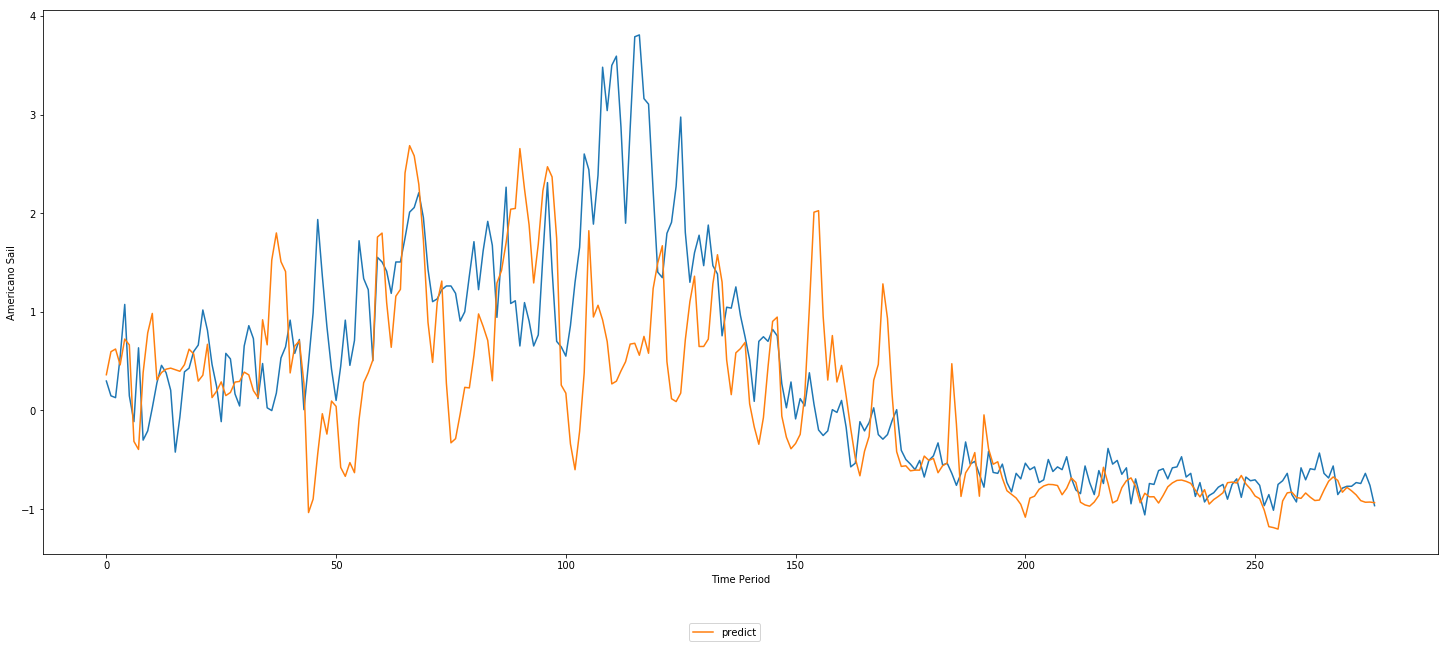

In [31]:
# Plot predictions
    ax = plt.figure(figsize = [25,10])
    plt.plot(testY[:,:])
    plt.plot(test_predict[:,:], label='predict')
    plt.xlabel("Time Period")
    plt.ylabel("Americano Sail")
    ax.legend(loc = 8)
    plt.show()

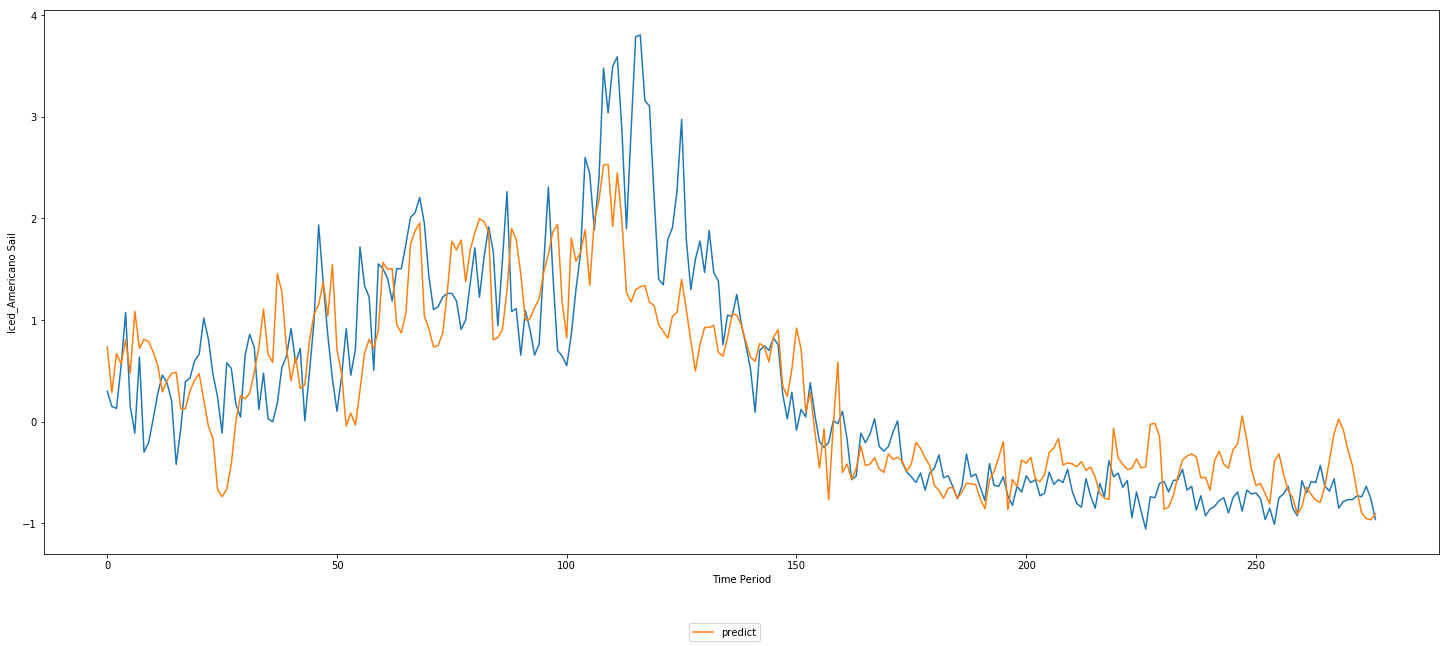

In [20]:
# Plot predictions
    ax2 = plt.figure(figsize = [25,10])
    plt.plot(testY[:,1])
    plt.plot(test_predict[:,1], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("Iced_Americano Sail")
    ax2.legend(loc = 8)
    plt.show()

In [21]:
# Plot predictions
    ax3 = plt.figure(figsize = [25,10])
    plt.plot(testY[:,2])
    plt.plot(test_predict[:,2], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("Caffe Moca Sail")
    ax3.legend(loc = 8)    
    plt.show()

In [22]:
# Plot predictions
    ax4 = plt.figure(figsize = [25,10])
    plt.plot(testY[:,3])
    plt.plot(test_predict[:,3], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("Caramel Matki Sail")
    ax4.legend(loc = 8)
    plt.show()

In [23]:
# Plot predictions
    plt.figure(figsize = [25,10])
    plt.plot(testY[:,4])
    plt.plot(test_predict[:,4], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("iced Americano Sail")
    ax.legend(loc = 8)
    plt.show()